Jhonn Carlos Castro

##Código para examinar .mat

### Cargar Drive

In [18]:
# Importar las bibliotecas necesarias
import scipy.io
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Listar los archivos en el directorio compartido para verificar la ruta
#!ls -R "/content/drive/MyDrive/MNIRED Drive"
!ls "/content/drive/MyDrive/MNIRED Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 1.png					  Fourier_transform_time_and_frequency_domains.gif
 2.png					  Load
'3 (1).png'				 'Model num.pdf'
 3.png					  Model.pdf
 4.png					  Normal
 bars.txt				  Others
 Diesel					 'Peak current vs frequency 0 deg.png'
'DieselRound- MALO'			 'Programa para paper métodos análisis.ipynb'
'EMT Signal Analyzer'			  Sincrono-Hidro
'Energy voltage vs frequency 0 deg.png'   Solar
 EscenariosSimulaciones			 'SP original.jpg'
 Fault					  Wind


### Extraer variables

In [19]:
# Especificar la ruta del archivo .mat en la carpeta compartida
file_path = '/content/drive/MyDrive/MNIRED Drive/Solar/Connection/10 MW/180.mat'

# Cargar el archivo .mat
mat = scipy.io.loadmat(file_path)

# Extraer las variables
t = mat['t']
Fs = mat['Fs'].item()
V1 = mat['V10']
I1 = mat['I10']

# Mostrar la variable para verificar que se ha cargado correctamente
print(V1.shape)
print(I1.shape)

(10001, 3)
(10001, 3)


## Análisis temporal

### Graficar señal pura

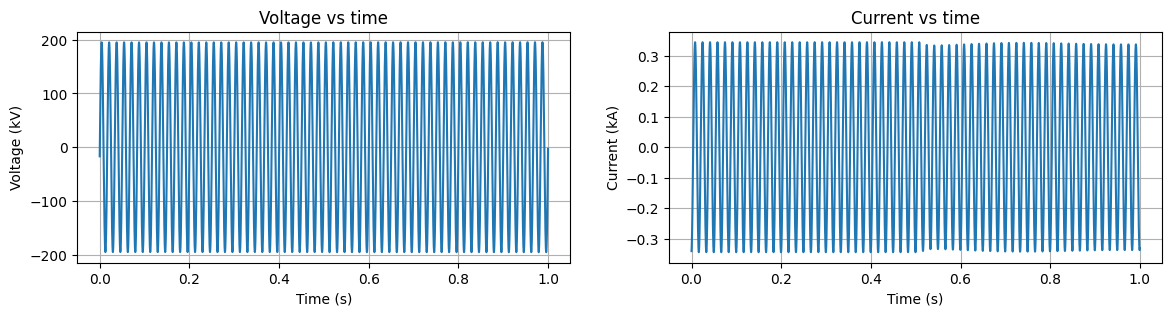

In [20]:
import matplotlib.pyplot as plt
import numpy as np

tension = V1[:, 1]
corriente = I1[:, 1]

plt.figure(figsize=(14, 3))

plt.subplot(1, 2, 1)
plt.plot(t,tension)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (kV)')
plt.title('Voltage vs time')

plt.subplot(1, 2, 2)
plt.plot(t,corriente)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Current (kA)')
plt.title('Current vs time')
plt.show()

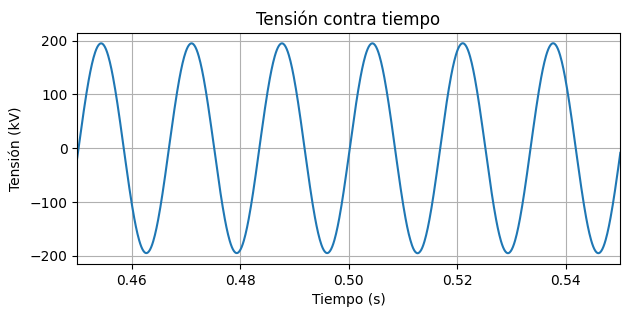

In [35]:
plt.figure(figsize=(7, 3))

#plt.subplot(1, 2, 1)
plt.plot(t,tension, label="Signal")
plt.xlim(0.45, 0.55)
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Tensión (kV)')
plt.title('Tensión contra tiempo')

#0.502777709689342
#plt.axvline(x=0.511111043022676, ymin=0.0, ymax=1000.0, color='r', label="Connection moment")

#plt.subplot(1, 2, 2)
#plt.plot(t,corriente)
#plt.xlim(0.45, 0.55)
#plt.grid()
#plt.xlabel('Time (s)')
#plt.ylabel('Current (kA)')
#plt.title('Current vs time')
#plt.legend()
plt.show()

### Gráfica RMS

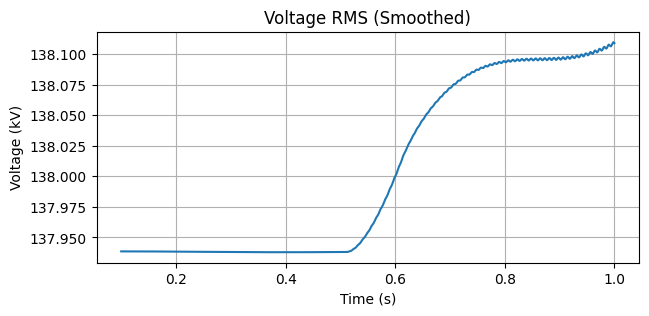

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que ya tienes las siguientes variables definidas:
time = t       # arreglo de tiempo
current_emt = tension  # señal EMT como arreglo de numpy

# Definir el tamaño de la ventana para la media móvil (ajustar según sea necesario)
window_size = 1000  # Ajustar el tamaño de la ventana para mayor suavidad

# Calcular el cuadrado de la señal EMT
current_emt_squared = current_emt**2

# Aplicar la media móvil al cuadrado de la señal EMT
current_rms_squared = pd.Series(current_emt_squared).rolling(window=window_size).mean()

# Tomar la raíz cuadrada del resultado para obtener la señal RMS
current_rms = np.sqrt(current_rms_squared)

# Aplicar un filtro de media móvil exponencial para suavizar aún más la señal RMS
current_rms_smoothed = current_rms.ewm(span=window_size).mean()

# Graficar las señales
plt.figure(figsize=(7, 3))

plt.plot(time, current_rms_smoothed)
plt.title('Voltage RMS (Smoothed)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (kV)')
#plt.ylim(136, 140)
plt.grid()

plt.show()


### Encontrar mejor Q para filtro Notch

In [23]:
import scipy.signal as signal
import numpy as np

f0 = 60.0  # Frecuencia a rechazar (60 Hz)
Q = np.linspace( 0.001 , 20 , 10000 )  # Factor de calidad del filtro notch
menor = 1000000000000000000
Q_min = 0

for q in Q:
  b, a = signal.iirnotch(f0, q, Fs)
  tension_filtered = signal.filtfilt(b, a, tension)
  suma = np.sum(np.abs(tension_filtered[1000:5000])) + np.sum(np.abs(tension_filtered[5500:9000]))
  if suma < menor:
    menor = suma
    Q_min = q

print(Q_min)

0.267013301330133


### Filtrar señal

In [24]:
# Diseñar el filtro notch para rechazar la frecuencia de 60 Hz
f0 = 60.0  # Frecuencia a rechazar (60 Hz)
Q = Q_min  # Factor de calidad del filtro notch

# Diseñar el filtro notch
b, a = signal.iirnotch(f0, Q, Fs)

# Aplicar el filtro a la señal
tension_filtered = signal.filtfilt(b, a, tension)
tension_filtered = signal.filtfilt(b, a, tension_filtered)

corriente_filtered = signal.filtfilt(b, a, corriente)
corriente_filtered = signal.filtfilt(b, a, corriente_filtered)

### Graficar señal filtrada

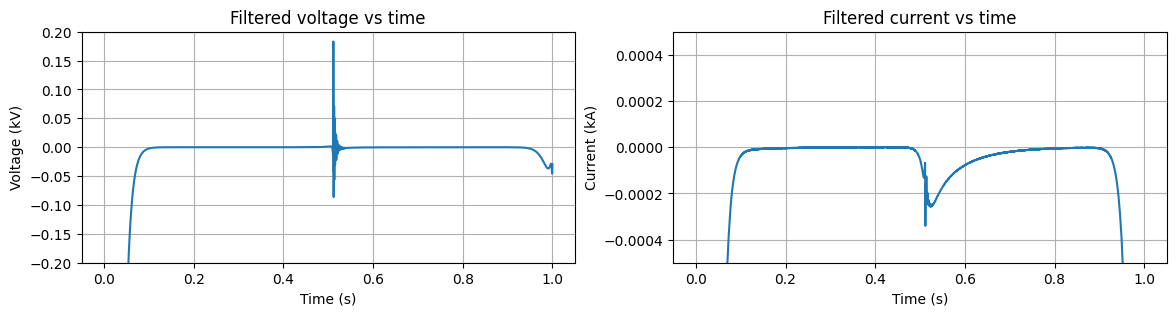

In [25]:
plt.figure(figsize=(14, 3))

plt.subplot(1, 2, 1)
plt.plot(t, tension_filtered)
plt.ylim(-0.2, 0.2)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (kV)')
plt.title('Filtered voltage vs time')

plt.subplot(1, 2, 2)
plt.plot(t, corriente_filtered)
plt.ylim(-0.0005, 0.0005)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Current (kA)')
plt.title('Filtered current vs time')
plt.show()

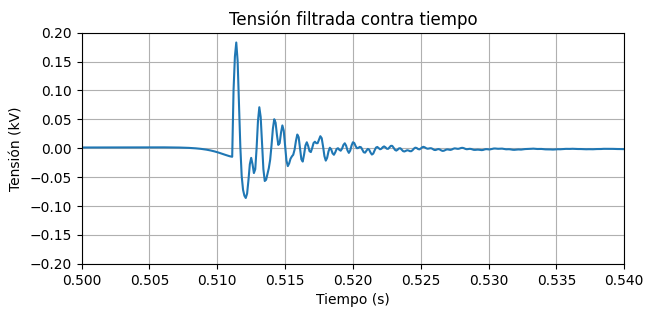

In [36]:
plt.figure(figsize=(7, 3))

#plt.subplot(1, 2, 1)
plt.plot(t, tension_filtered)
plt.xlim(0.5, 0.54)
plt.ylim(-0.2, 0.2)
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Tensión (kV)')
plt.title('Tensión filtrada contra tiempo')

#plt.subplot(1, 2, 2)
#plt.plot(t, corriente_filtered)
#plt.xlim(0.45, 0.55)
#plt.ylim(-0.01, 0.01)
#plt.grid()
#plt.xlabel('Time (s)')
#plt.ylabel('Current (kA)')
#plt.title('Filtered current vs time')

plt.show()

## Análisis tiempo - frecuencia

### Imagen wavelet

In [27]:
!pip install PyWavelets
import pywt

In [28]:
# Define el rango de frecuencias a analizar
frequencies = np.linspace(1 , 2000 , num=1000) / Fs

# Define la wavelet Morlet con parámetros específicos
mother_wavelet = 'morl'

# Calcula las escalas correspondientes a las frecuencias deseadas
scales = pywt.frequency2scale(mother_wavelet, frequencies)

# Calcula la CWT
coefficients_V, frequencies_V = pywt.cwt( tension, scales, mother_wavelet, sampling_period = 1.0/Fs )
coefficients_I, frequencies_I = pywt.cwt( corriente, scales, mother_wavelet, sampling_period = 1.0/Fs )

coefficients_fV, frequencies_fV = pywt.cwt( tension_filtered, scales, mother_wavelet, sampling_period = 1.0/Fs )
coefficients_fI, frequencies_fI = pywt.cwt( corriente_filtered, scales, mother_wavelet, sampling_period = 1.0/Fs )

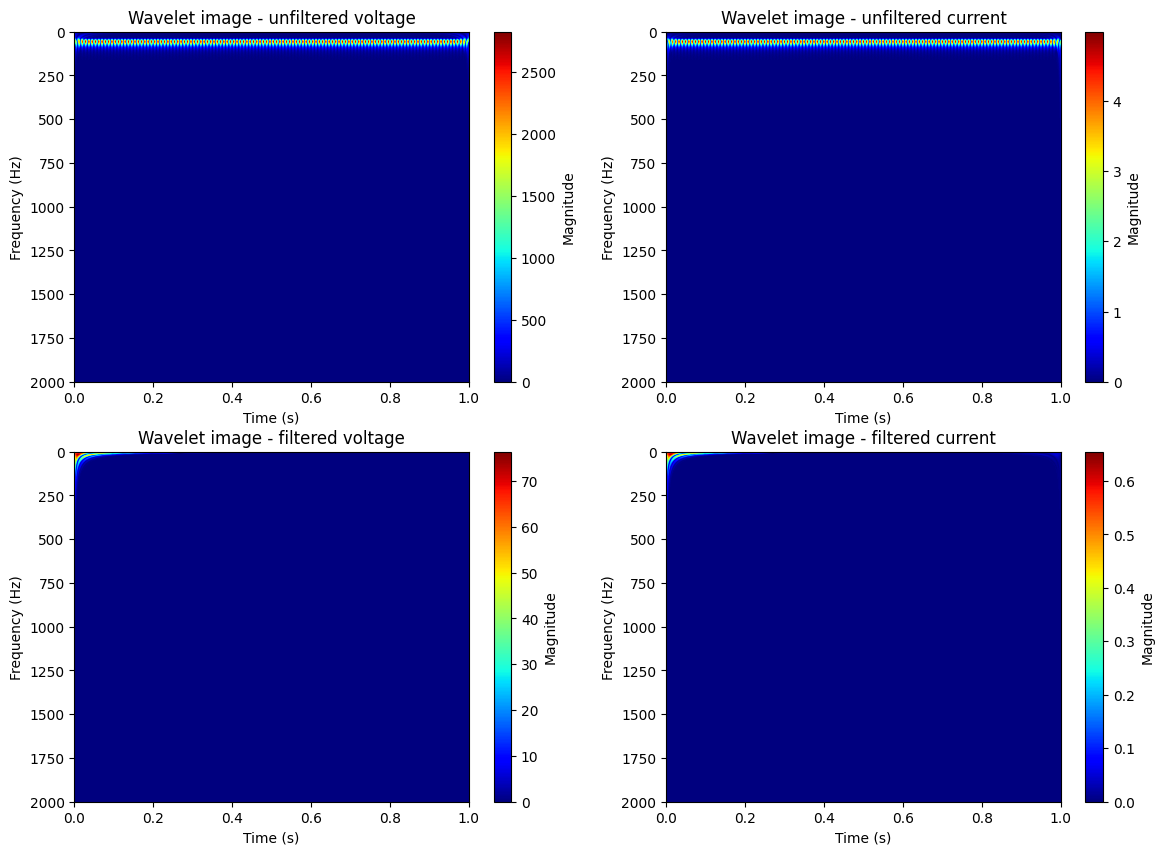

In [29]:
# Visualiza los resultados
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.imshow(np.abs(coefficients_V), extent=[0, len(tension) / Fs, frequencies_V[-1], 0], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Wavelet image - unfiltered voltage')

plt.subplot(2, 2, 2)
plt.imshow(np.abs(coefficients_I), extent=[0, len(corriente) / Fs, frequencies_I[-1], 0], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Wavelet image - unfiltered current')

plt.subplot(2, 2, 3)
plt.imshow(np.abs(coefficients_fV), extent=[0, len(tension_filtered) / Fs, frequencies_fV[-1], 0], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Wavelet image - filtered voltage')

plt.subplot(2, 2, 4)
plt.imshow(np.abs(coefficients_fI), extent=[0, len(corriente_filtered) / Fs, frequencies_fI[-1], 0], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Wavelet image - filtered current')

plt.show()

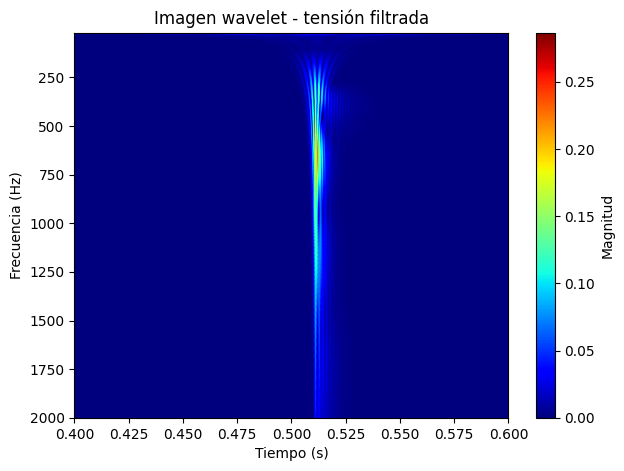

In [40]:
plt.figure(figsize=(7, 5))
plt.imshow(np.abs(coefficients_fV[4:999 , round(Fs*0.4) : round(Fs*0.6)]), extent=[0.4, 0.6, frequencies_fI[-1], 20], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitud')
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.title('Imagen wavelet - tensión filtrada')
plt.show()

## Análisis frecuencial

### Impedancia

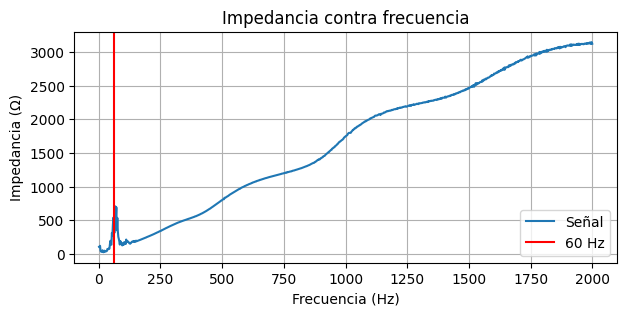

In [42]:
def rms(values):
    return np.sqrt(np.mean(np.square(values)))

def calculate_rms_ratio(coefficients_fV, coefficients_fI, start_time, end_time, time_vector):
    # Asegurarse de que las matrices tengan el mismo número de filas y columnas
    assert coefficients_fV.shape == coefficients_fI.shape, "Las matrices deben tener la misma forma"

    # Encuentra los índices más cercanos al intervalo de tiempo dado
    start_idx = np.argmin(np.abs(time_vector - start_time))
    end_idx = np.argmin(np.abs(time_vector - end_time)) + 1  # +1 para incluir el end_idx en el intervalo

    # Número de filas (frecuencias)
    num_frequencies = coefficients_fV.shape[0]

    # Inicializa el arreglo Z
    Z = np.zeros(num_frequencies)

    for i in range(num_frequencies):
        # Extrae el intervalo de tiempo para cada frecuencia
        segment_fV = coefficients_fV[i, start_idx:end_idx]
        segment_fI = coefficients_fI[i, start_idx:end_idx]

        # Asegúrate de que los segmentos no estén vacíos
        if segment_fV.size == 0 or segment_fI.size == 0:
            raise ValueError("El intervalo de tiempo especificado no contiene datos.")

        # Calcula el RMS de cada segmento
        rms_fV = rms(segment_fV)
        rms_fI = rms(segment_fI)

        # Calcula la relación de los RMS y almacena en Z
        Z[i] = rms_fV / rms_fI

    return Z

# Ejemplo de uso
#coefficients_fV = np.random.rand(5, 100)  # Reemplaza con tu matriz real
#coefficients_fI = np.random.rand(5, 100)  # Reemplaza con tu matriz real
time_vector = t#np.linspace(0, 1, 100)  # Vector de tiempo correspondiente

start_time = 0.4
end_time = 0.6

Z = calculate_rms_ratio(coefficients_fV, coefficients_fI, start_time, end_time, time_vector)

plt.figure(figsize=(7, 3))

# Asigna etiquetas a las líneas
plt.plot(frequencies_V, Z, label="Señal")
plt.axvline(x=60, ymin=0.0, ymax=1000.0, color='r', label="60 Hz")

plt.grid()
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Impedancia (Ω)')
plt.title('Impedancia contra frecuencia')

# Agrega la leyenda
plt.legend()

plt.show()

### Energía y picos

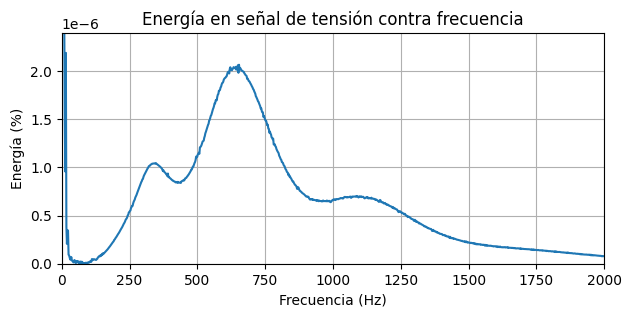

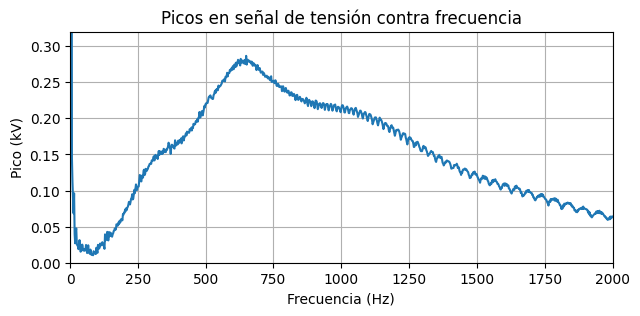

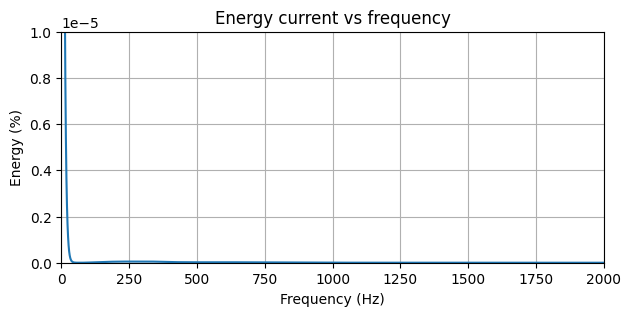

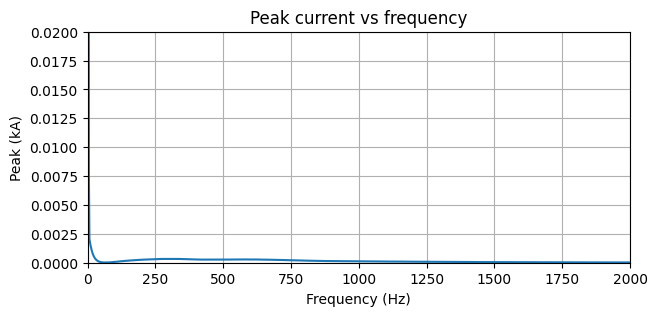

In [37]:
def split_matrix_by_time(coefficients, time_vector):
    sections = {
        'first_boundary': (0, 0.2),
        'first_non_transient': (0.2, 0.45),
        'transient': (0.45, 0.55),
        'second_non_transient': (0.55, 0.8),
        'second_boundary': (0.8, time_vector[-1])
    }

    split_data = {}
    for section, (start, end) in sections.items():
        start_idx = np.argmin(np.abs(time_vector - start))
        end_idx = np.argmin(np.abs(time_vector - end)) + 1  # +1 to include the end_idx in the range
        split_data[section] = coefficients[:, start_idx:end_idx]

    return split_data

def energy_analysis(transient_matrix):
    numerator = np.sum(transient_matrix ** 2, axis=1)
    denominator = np.sum(transient_matrix ** 2)
    energy = numerator / denominator
    return energy

def peak_analysis(transient_matrix):
    peaks = np.max(np.abs(transient_matrix), axis=1)
    return peaks

split_data_V = split_matrix_by_time(coefficients_fV, t)
split_data_I = split_matrix_by_time(coefficients_fI, t)

transient_matrix_V = split_data_V['transient']
transient_matrix_I = split_data_I['transient']

energy_V = energy_analysis(transient_matrix_V)
peaks_V = peak_analysis(transient_matrix_V)

energy_I = energy_analysis(transient_matrix_I)
peaks_I = peak_analysis(transient_matrix_I)

#plt.figure(figsize=(14, 10))

#plt.subplot(2, 2, 1)
plt.figure(figsize=(7, 3))
plt.plot(frequencies_V, energy_V)
plt.grid()
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Energía (%)')
plt.title('Energía en señal de tensión contra frecuencia')
plt.xlim(0, 2000)
plt.ylim(0, 0.0000024)
plt.show()

#plt.subplot(2, 2, 3)
plt.figure(figsize=(7, 3))
plt.plot(frequencies_V, peaks_V)
plt.grid()
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Pico (kV)')
plt.title('Picos en señal de tensión contra frecuencia')
plt.xlim(0, 2000)
plt.ylim(0, 0.32)
plt.show()

#plt.subplot(2, 2, 2)
plt.figure(figsize=(7, 3))
plt.plot(frequencies_I, energy_I)
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy (%)')
plt.title('Energy current vs frequency')
plt.xlim(0, 2000)
plt.ylim(0, 0.00001)
plt.show()

#plt.subplot(2, 2, 4)
plt.figure(figsize=(7, 3))
plt.plot(frequencies_I, peaks_I)
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Peak (kA)')
plt.title('Peak current vs frequency')
plt.xlim(0, 2000)
plt.ylim(0, 0.02)
plt.show()

### Índices de selectividad

#### Preliminares

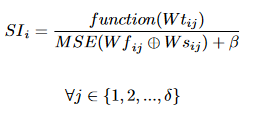

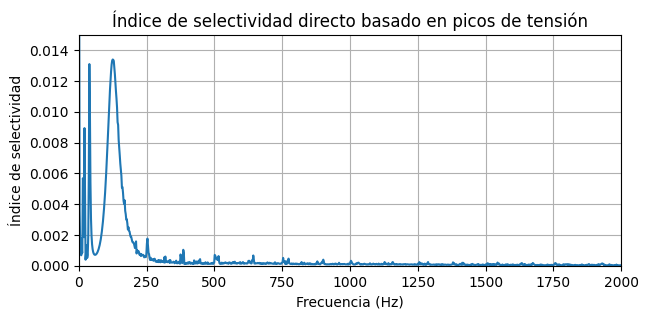

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def split_matrix_by_time(coefficients, time_vector):
    sections = {
        'first_boundary': (0, 0.2),
        'first_non_transient': (0.2, 0.45),
        'transient': (0.45, 0.55),
        'second_non_transient': (0.55, 0.8),
        'second_boundary': (0.8, time_vector[-1])
    }

    split_data = {}
    for section, (start, end) in sections.items():
        start_idx = np.argmin(np.abs(time_vector - start))
        end_idx = np.argmin(np.abs(time_vector - end)) + 1  # +1 to include the end_idx in the range
        split_data[section] = coefficients[:, start_idx:end_idx]

    return split_data

def energy_analysis(transient_matrix):
    numerator = np.sum(transient_matrix ** 2, axis=1)
    denominator = np.sum(transient_matrix ** 2)
    energy = numerator / denominator
    return energy

def peak_analysis(transient_matrix):
    peaks = np.max(np.abs(transient_matrix), axis=1)
    return peaks

def mse_per_frequency(matrix):
    zero_matrix = np.zeros_like(matrix)
    mse_values = np.mean((matrix - zero_matrix) ** 2, axis=1)
    return mse_values

def calculate_si(function_values, mse_values, beta):
    return function_values / (mse_values + beta)


split_data_fV = split_matrix_by_time(coefficients_V, t)
split_data_fI = split_matrix_by_time(coefficients_I, t)

transient_matrix_fV = split_data_fV['transient']
transient_matrix_fI = split_data_fI['transient']

# Análisis de energía y picos para tensión
energy_fV = energy_analysis(transient_matrix_fV)
peaks_fV = peak_analysis(transient_matrix_fV)

# Análisis de energía y picos para corriente
energy_fI = energy_analysis(transient_matrix_fI)
peaks_fI = peak_analysis(transient_matrix_fI)

# Concatenar horizontalmente las primeras y segundas zonas no transitorias para tensión y corriente
first_second_non_transient_fV = np.hstack((split_data_fV['first_non_transient'], split_data_fV['second_non_transient']))
first_second_non_transient_fI = np.hstack((split_data_fI['first_non_transient'], split_data_fI['second_non_transient']))

# Calcular el MSE comparando con la matriz de ceros frecuencia por frecuencia
mse_fV = mse_per_frequency(first_second_non_transient_fV)
mse_fI = mse_per_frequency(first_second_non_transient_fI)

# Calcular beta (el valor máximo de la función de energía o picos)
beta_energy_fV = np.max(energy_fV)
beta_peaks_fV = np.max(peaks_fV)
beta_energy_fI = np.max(energy_fI)
beta_peaks_fI = np.max(peaks_fI)

# Calcular SI para cada opción
si_energy_fV = calculate_si(energy_fV, mse_fV, beta_energy_fV)
si_peaks_fV = calculate_si(peaks_fV, mse_fV, beta_peaks_fV)
si_energy_fI = calculate_si(energy_fI, mse_fI, beta_energy_fI)
si_peaks_fI = calculate_si(peaks_fI, mse_fI, beta_peaks_fI)

plt.figure(figsize=(7, 3))
plt.plot(frequencies_V, si_peaks_fV)
plt.grid()
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Índice de selectividad')
plt.title('Direct selectivity index from voltage peak analysis vs frequency')
plt.title('Índice de selectividad directo basado en picos de tensión')
plt.xlim(0, 2000)
plt.ylim(0, 0.015)
plt.show()

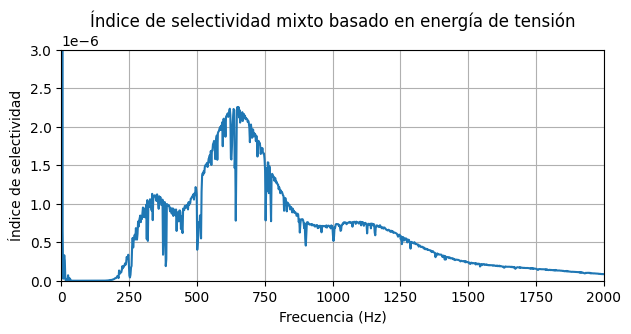

In [39]:
split_data_fV = split_matrix_by_time(coefficients_fV, t)
split_data_V = split_matrix_by_time(coefficients_V, t)

transient_matrix_fV = split_data_fV['transient']

energy_fV = energy_analysis(transient_matrix_fV)

first_second_non_transient_V = np.hstack((split_data_V['first_non_transient'], split_data_V['second_non_transient']))

mse_V = mse_per_frequency(first_second_non_transient_V)

beta_energy_fV = np.max(energy_fV)

si_energy = calculate_si(energy_fV, mse_V, beta_energy_fV)

plt.figure(figsize=(7, 3))
plt.plot(frequencies_V, si_energy)
plt.grid()
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Índice de selectividad')
plt.title('Mixed selectivity index from voltage energy analysis vs frequency')
plt.title('Índice de selectividad mixto basado en energía de tensión')
plt.xlim(0, 2000)
plt.ylim(0, 0.000003)
plt.show()